In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Obtenir les données de tirs NBA (LeBron + tous les joueurs)
def get_shotchart(player_id, season='2024-25'):
    chart = shotchartdetail.ShotChartDetail(
        team_id=0,
        player_id=player_id,
        season_type_all_star='Regular Season',
        season_nullable=season,
        context_measure_simple='FGA'
    )
    return chart.get_data_frames()[0]

# Récupérer ID de LeBron James
lebron = [p for p in players.get_active_players() if p['full_name'] == 'Stephen Curry'][0]
lebron_id = lebron['id']

# Charger les tirs de LeBron et de toute la ligue
df_lebron = get_shotchart(lebron_id)
df_league = get_shotchart(0)  # 0 = tous les joueurs

# On garde les tirs dans le demi-terrain
df_lebron = df_lebron[df_lebron['LOC_Y'] <= 470]
df_league = df_league[df_league['LOC_Y'] <= 470]




In [2]:
# Créer une fonction pour bin les tirs et calculer la FG%
def compute_hexbins(df, gridsize=30):
    from scipy.stats import binned_statistic_2d

    made = df['SHOT_MADE_FLAG']
    x = df['LOC_X']
    y = df['LOC_Y']

    # FG%
    fg_pct, xedges, yedges, _ = binned_statistic_2d(
        x, y, made, statistic='mean', bins=gridsize, expand_binnumbers=True
    )

    # Volume
    shot_counts, _, _, _ = binned_statistic_2d(
        x, y, made, statistic='count', bins=gridsize
    )

    return fg_pct.T, shot_counts.T, xedges, yedges

# Calcul des FG% par zone
fg_lebron, count_lebron, xedges, yedges = compute_hexbins(df_lebron)
fg_league, count_league, _, _ = compute_hexbins(df_league)

# Calcul de l'efficacité relative (différence LeBron - moyenne NBA)
diff_fg = fg_lebron - fg_league

# Position des centres d’hexagones
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)


In [3]:
# 🎨 Fonction pour dessiner le terrain
def draw_court(ax=None, color='white', lw=2):
    if ax is None:
        ax = plt.gca()
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    paint = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    free_throw = Circle((0, 142.5), 60, linewidth=lw, color=color, fill=False)
    top_free = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, color=color, lw=lw)
    bottom_free = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, color=color, lw=lw, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, color=color, lw=lw)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, color=color, lw=lw)
    center_circle = Circle((0, 422.5), 60, linewidth=lw, color=color, fill=False)

    for element in [hoop, backboard, paint, free_throw, top_free, bottom_free,
                    restricted, corner_three_a, corner_three_b, three_arc, center_circle]:
        ax.add_patch(element)

    ax.set_xlim(-250, 250)
    ax.set_ylim(-50, 470)
    ax.axis('off')



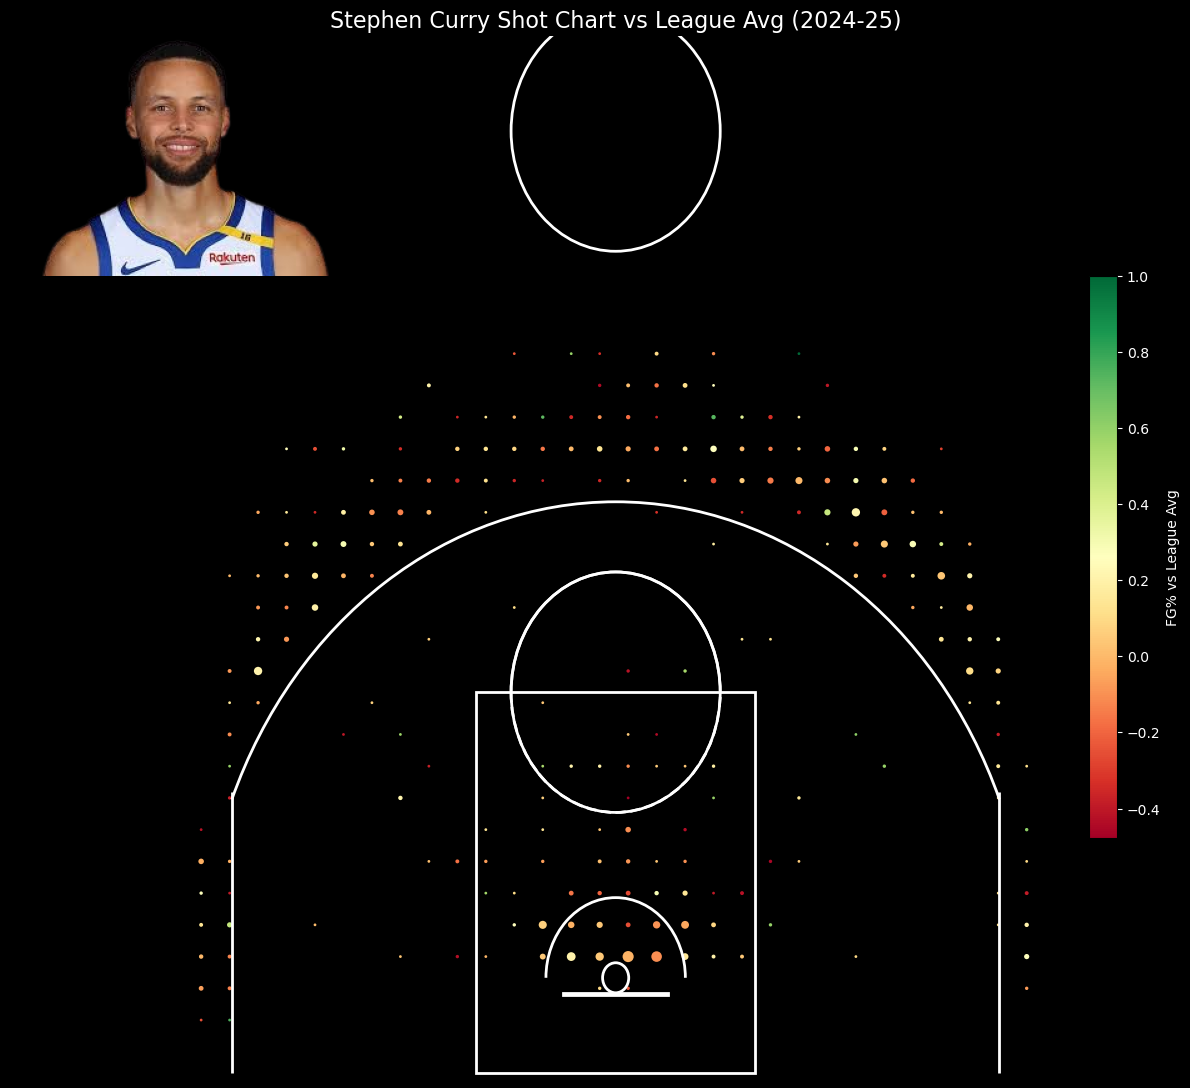

In [4]:
# 🎯 Tracé final
fig, ax = plt.subplots(figsize=(12, 11), facecolor='black')

# Masquer les zones sans volume de tir
mask = count_lebron >= 2  # au moins 2 tirs tentés
sc = ax.scatter(
    X[mask], Y[mask],
    c=diff_fg[mask],
    s=count_lebron[mask]*2,  # taille ~ volume
    cmap='RdYlGn',
    edgecolors='none'
)

draw_court(ax, color='white')
ax.set_facecolor('black')
cb = fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.04)
cb.set_label('FG% vs League Avg', color='white')
cb.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

# 📸 Charger l'image
img_path = 'Curry.png'  # Remplace par le chemin de ton image
img = mpimg.imread(img_path)
imagebox = OffsetImage(img, zoom=0.9)  # ajuste le zoom selon la taille de l'image

# 📍 Positionner l’image (ex: en haut à gauche)
ab = AnnotationBbox(imagebox, (-250, 410), frameon=False)
ax.add_artist(ab)


ax.set_title("Stephen Curry Shot Chart vs League Avg (2024-25)", color='white', fontsize=16)
plt.tight_layout()
plt.show()


In [5]:
fig.savefig('LeBron James Shot Chart.png', bbox_inches='tight')


Des hexagones colorés selon la différence de réussite par rapport à la moyenne NBA :

Vert = LeBron est meilleur que la moyenne NBA à cet endroit.

Rouge = LeBron est moins bon que la moyenne NBA à cet endroit.

Jaune / Orange = Près de la moyenne.

👉 Analyse :

Proche du panier (0-5 pieds) : Beaucoup de vert vif → LeBron reste ultra efficace au cercle, bien meilleur que la moyenne.

Mi-distance (entre 10 et 22 pieds) : Beaucoup de rouge/orange → Il est moins performant que la moyenne sur les tirs mid-range (logique vu son âge et son évolution de style de jeu).

3 points (corners) :

Corner gauche : Un peu de vert → il reste fiable sur les tirs de coin.

Top of the key (arc central) : Des zones plutôt jaunes/rouges → moins de réussite à 3 points au-dessus de la tête de la défense.

Tir en périphérie (ailes) : Léger vert → Il est plus efficace sur certaines ailes, souvent après un catch-and-shoot.

👉 Résumé :

LeBron reste dominant près du cercle, mais son tir extérieur montre des hauts et des bas. Il est très dangereux dans les corners mais moins stable en haut de l'arc.